<a href="https://colab.research.google.com/github/JakeSiewJK64/colabNotebooks/blob/master/titanic_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

In [36]:
url = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
titanic_dataset = pd.read_csv(url)
titanic_dataset.iloc[:5]

pd.set_option('display.width', None)

titanic_features = titanic_dataset.copy()
titanic_labels = titanic_features.pop('survived')
titanic_features.iloc[:5]

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [34]:
titanic_labels.iloc[:5]

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

# Example of Keras functional API


In [41]:
# CREATE A SYMBOLIC INPUT
input = tf.keras.Input(shape=(), dtype=tf.float32)
print(input)
result = 2 * input + 1
print(result)

KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None), name='tf.__operators__.add_2/AddV2:0', description="created by layer 'tf.__operators__.add_2'")


In [46]:
calc = tf.keras.Model(inputs=input, outputs=result)
print("1 * 2 + 1 = %d" % calc(1).numpy())
print("8 * 2 + 1 = %d" % calc(8).numpy())

1 * 2 + 1 = 3
8 * 2 + 1 = 17


In [59]:
inputs = {}
for name, col in titanic_features.items():
    dtype = col.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>,
 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>}

In [72]:
numeric_inputs = {name:input for name, input in inputs.items() if input.dtype==tf.float32}
for name, items in numeric_inputs.items():
    print(name)

age
n_siblings_spouses
parch
fare


In [73]:
# CONCATENATE THE NUMERIC VALUES TOGETHER
x = layers.Concatenate()(list(numeric_inputs.values()))

# CREATING THE NORMALIZATION FUNCTION
normalize = preprocessing.Normalization()
normalize.adapt(np.array(titanic_dataset[numeric_inputs.keys()]))

all_numeric_inputs = normalize(x)
all_numeric_inputs

preprocessed_inputs = [all_numeric_inputs]
preprocessed_inputs

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization_4')>]

In [77]:
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
    lookup = preprocessing.StringLookup(vocabulary=np.unique(titanic_features[name]))
    one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())
    x = lookup(input)
    x = one_hot(x)
x

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_5')>

In [78]:
preprocessed_inputs.append(x)

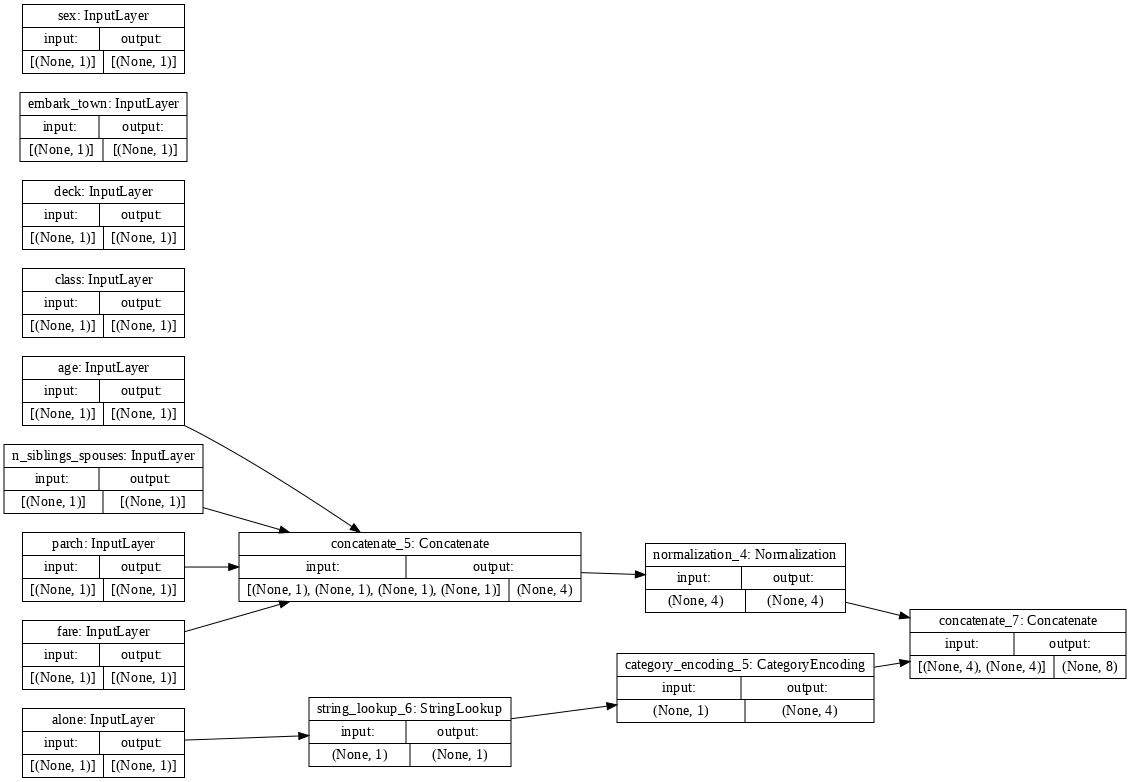

In [81]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# BUILDING THE MODEL
titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

# PLOTTING THE MODEL
tf.keras.utils.plot_model(model = titanic_preprocessing, rankdir='LR', dpi = 72, show_shapes=True)

In [83]:
titanic_features_dict = {
    name:np.array(value) for name, value in titanic_features.items()
}

In [88]:
# SLICE OUT THE SUVIVED LABEL TRAINING EXAMPLE AND PASS INTO PREPROCESSING MODEL
features_dict = {name:values[:1] for name, values, in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[-0.6104149 ,  0.39519805, -0.4790527 , -0.4974028 ,  0.        ,
         0.        ,  1.        ,  0.        ]], dtype=float32)>

In [99]:
def titanic_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        layers.Dense(64),
        layers.Dense(1)
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.optimizers.Adam())

    return model

In [100]:
titanic_model = titanic_model(titanic_preprocessing, inputs)

In [102]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

Epoch 1/10
20/20 [==============================] - 1s 1ms/step - loss: 0.6504
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.6123
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.6079
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5913
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6087
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.6108
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5920
Epoch 8/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5868
Epoch 9/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5835
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 0.6059


In [103]:
titanic_model.save('test')

INFO:tensorflow:Assets written to: test/assets


In [105]:
reloaded = tf.keras.models.load_model('test')
reloaded

In [107]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
features_dict

{'age': array([22.]),
 'alone': array(['n'], dtype=object),
 'class': array(['Third'], dtype=object),
 'deck': array(['unknown'], dtype=object),
 'embark_town': array(['Southampton'], dtype=object),
 'fare': array([7.25]),
 'n_siblings_spouses': array([1]),
 'parch': array([0]),
 'sex': array(['male'], dtype=object)}

In [110]:
before = titanic_model(features_dict)
after = reloaded(features_dict)
print(before)
print(after)

tf.Tensor([[-0.21285848]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.21285848]], shape=(1, 1), dtype=float32)


In [111]:
import itertools

def slices(features):
    for i in itertools.count():
        # FOR EACH FEATURE TAKE INDEX 'i'
        example = {name:values[i] for name, values in features.items()}
        yield example    

In [113]:
for example in slices(titanic_features_dict):
    for name, value in example.items():
        print(f"{name:19s}: {value}")
    break

sex                : male
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : Third
deck               : unknown
embark_town        : Southampton
alone              : n


In [120]:
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)
features_ds

<TensorSliceDataset shapes: {sex: (), age: (), n_siblings_spouses: (), parch: (), fare: (), class: (), deck: (), embark_town: (), alone: ()}, types: {sex: tf.string, age: tf.float64, n_siblings_spouses: tf.int64, parch: tf.int64, fare: tf.float64, class: tf.string, deck: tf.string, embark_town: tf.string, alone: tf.string}>

In [123]:
for example in features_ds:
    for name, value in example.items():
        print(f"{name:19s}: {value}")
    break

sex                : b'male'
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : b'Third'
deck               : b'unknown'
embark_town        : b'Southampton'
alone              : b'n'


In [124]:
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))
titanic_ds

<TensorSliceDataset shapes: ({sex: (), age: (), n_siblings_spouses: (), parch: (), fare: (), class: (), deck: (), embark_town: (), alone: ()}, ()), types: ({sex: tf.string, age: tf.float64, n_siblings_spouses: tf.int64, parch: tf.int64, fare: tf.float64, class: tf.string, deck: tf.string, embark_town: tf.string, alone: tf.string}, tf.int64)>

In [125]:
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

In [130]:
titanic_model.fit(titanic_batches, epochs=10)

Epoch 1/10
20/20 [==============================] - 0s 4ms/step - loss: 0.5924
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5946
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5928
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5929
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5930
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5929
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5924
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5933
Epoch 9/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5926
Epoch 10/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5927


In [133]:
# READING CSV FILES USING KERAS UTILS GET FILE FUNCTION
titanic_file_path = tf.keras.utils.get_file('train.csv', "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
print(titanic_file_path)

/root/.keras/datasets/train.csv


In [135]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    file_pattern=titanic_file_path,
    batch_size=5, 
    label_name='survived',
    num_epochs=10,
    ignore_errors=False
)
titanic_csv_ds

<PrefetchDataset shapes: (OrderedDict([(sex, (None,)), (age, (None,)), (n_siblings_spouses, (None,)), (parch, (None,)), (fare, (None,)), (class, (None,)), (deck, (None,)), (embark_town, (None,)), (alone, (None,))]), (None,)), types: (OrderedDict([(sex, tf.string), (age, tf.float32), (n_siblings_spouses, tf.int32), (parch, tf.int32), (fare, tf.float32), (class, tf.string), (deck, tf.string), (embark_town, tf.string), (alone, tf.string)]), tf.int32)>

In [136]:
for batch, label in titanic_csv_ds.take(1):
    for key, value in batch.items():
        print(f"{key:20s}:{value}")
    print(f"\n{'label':20s}: {label}")


sex                 :[b'female' b'male' b'male' b'female' b'female']
age                 :[34. 40. 28. 28. 39.]
n_siblings_spouses  :[0 0 8 1 1]
parch               :[0 0 2 0 5]
fare                :[13.     27.7208 69.55   24.15   31.275 ]
class               :[b'Second' b'First' b'Third' b'Third' b'Third']
deck                :[b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         :[b'Southampton' b'Cherbourg' b'Southampton' b'Queenstown' b'Southampton']
alone               :[b'y' b'y' b'n' b'n' b'n']

label               : [1 0 0 1 0]
